In [1]:
!pip install tensorflow opencv-python matplotlib albumentations

   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   --- ------------------------------------ 3.4/38.9 MB 22.3 MB/s eta 0:00:02
   ---- ----------------------------------- 4.7/38.9 MB 10.9 MB/s eta 0:00:04
   ----- ---------------------------------- 5.8/38.9 MB 9.3 MB/s eta 0:00:04
   ------ --------------------------------- 6.3/38.9 MB 8.4 MB/s eta 0:00:04
   ------- -------------------------------- 6.8/38.9 MB 6.6 MB/s eta 0:00:05
   ------- -------------------------------- 7.1/38.9 MB 5.7 MB/s eta 0:00:06
   ------- -------------------------------- 7.3/38.9 MB 5.2 MB/s eta 0:00:07
   -------- ------------------------------- 7.9/38.9 MB 4.6 MB/s eta 0:00:07
   -------- ------------------------------- 8.4/38.9 MB 4.3 MB/s eta 0:00:08
   --------- ------------------------------ 8.9/38.9 MB 4.2 MB/s eta 0:00:08
   --------- ------------------------------ 9.7/38.9 MB 4.1 MB/s eta 0:00:08
   ---------- ----------------------------- 10.5/38.9 MB 4.0 MB/s eta 0:00:08
   

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
monai 1.4.0 requires numpy<2.0,>=1.24, but you have numpy 2.1.3 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[INFO] Using device: cuda
[INFO] Loaded 547 images and masks.


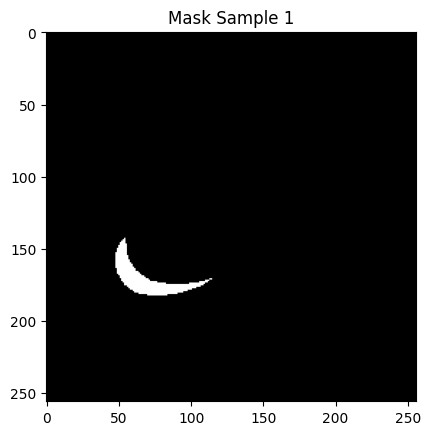

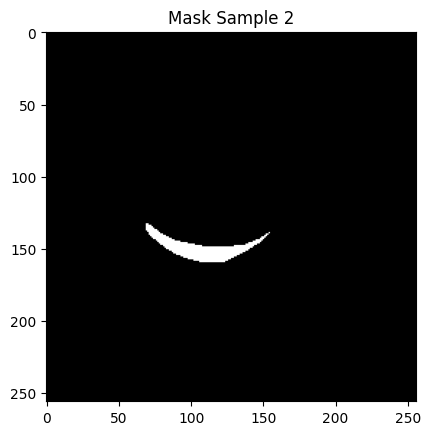

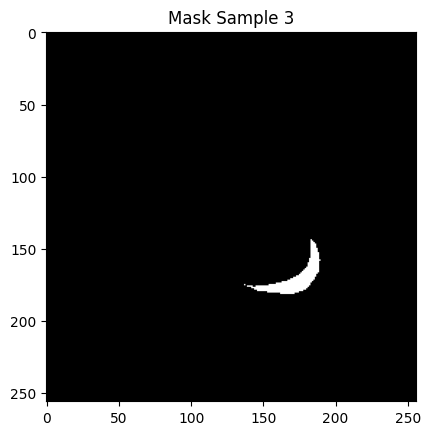

[INFO] Dataset split into training and validation sets.
[INFO] Starting training...
[INFO] Epoch 1/50 | Loss: 0.6586 | Dice: 0.0000
[INFO] Epoch 2/50 | Loss: 0.5085 | Dice: 0.0000
[INFO] Epoch 3/50 | Loss: 0.3209 | Dice: 0.3030
[INFO] Epoch 4/50 | Loss: 0.1934 | Dice: 0.6804
[INFO] Epoch 5/50 | Loss: 0.1655 | Dice: 0.7259
[INFO] Epoch 6/50 | Loss: 0.1708 | Dice: 0.7149
[INFO] Epoch 7/50 | Loss: 0.1527 | Dice: 0.7434
[INFO] Epoch 8/50 | Loss: 0.1498 | Dice: 0.7473
[INFO] Epoch 9/50 | Loss: 0.1429 | Dice: 0.7585
[INFO] Epoch 10/50 | Loss: 0.1352 | Dice: 0.7705
[INFO] Epoch 11/50 | Loss: 0.1300 | Dice: 0.7787
[INFO] Epoch 12/50 | Loss: 0.1268 | Dice: 0.7835
[INFO] Epoch 13/50 | Loss: 0.1384 | Dice: 0.7641
[INFO] Epoch 14/50 | Loss: 0.1333 | Dice: 0.7740
[INFO] Epoch 15/50 | Loss: 0.1251 | Dice: 0.7877
[INFO] Epoch 16/50 | Loss: 0.1195 | Dice: 0.7970
[INFO] Epoch 17/50 | Loss: 0.1200 | Dice: 0.7948
[INFO] Epoch 18/50 | Loss: 0.1163 | Dice: 0.8002
[INFO] Epoch 19/50 | Loss: 0.1154 | Dice: 0

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from sklearn.model_selection import train_test_split

# Set updated paths
IMAGE_DIR = r"D:\IITB\Conjunctiva Detection\Eye Conjunctiva Segmentation Dataset\Images"
MASK_DIR = r"D:\IITB\Conjunctiva Detection\Eye Conjunctiva Segmentation Dataset\Masks Annotator 1"
IMG_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {DEVICE}")

# 2. Load and preprocess dataset

def load_data(img_dir, mask_dir, img_size):
    images = []
    masks = []
    filenames = sorted(os.listdir(img_dir), key=lambda x: int(x.split('.')[0]))
    for filename in filenames:
        img_path = os.path.join(img_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0

        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask[:, :, 2]  # Extract red channel
        mask = (mask > 50).astype(np.float32)  # Threshold red channel
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    print(f"[INFO] Loaded {len(images)} images and masks.")

    # Sanity check: visualize first 3 masks
    for i in range(3):
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Mask Sample {i+1}")
        plt.show()

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

images, masks = load_data(IMAGE_DIR, MASK_DIR, IMG_SIZE)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
print("[INFO] Dataset split into training and validation sets.")

# 3. Data augmentation
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3)
])

def augment_data(images, masks):
    aug_imgs, aug_masks = [], []
    for img, mask in zip(images, masks):
        augmented = augment(image=img, mask=mask[:,:,0])
        aug_img = augmented['image']
        aug_mask = augmented['mask']
        aug_mask = np.expand_dims(aug_mask, axis=-1)
        aug_imgs.append(aug_img)
        aug_masks.append(aug_mask)
    return np.array(aug_imgs), np.array(aug_masks)

aug_X_train, aug_y_train = augment_data(X_train, y_train)

# 4. Custom Dataset
class ConjunctivaDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].transpose(2, 0, 1)
        mask = self.masks[idx].transpose(2, 0, 1)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

train_dataset = ConjunctivaDataset(aug_X_train, aug_y_train)
val_dataset = ConjunctivaDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# 5. U-Net Model in PyTorch
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = CBR(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.out(d1))

model = UNet().to(DEVICE)

# Combined BCE + Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.contiguous()
        targets = targets.contiguous()
        intersection = (preds * targets).sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.smooth)
        return 1 - dice.mean()

dice_loss_fn = DiceLoss()
bce_loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def combined_loss(preds, targets):
    return 0.5 * bce_loss_fn(preds, targets) + 0.5 * dice_loss_fn(preds, targets)

# Dice score metric

def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum().item()
    total = preds.sum().item() + targets.sum().item()
    if total == 0:
        return 1.0
    dice = (2. * intersection) / total
    return dice

# 6. Train model
EPOCHS = 50
print("[INFO] Starting training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_dice = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_dice += dice_score(preds, masks)
    avg_loss = train_loss / len(train_loader)
    avg_dice = train_dice / len(train_loader)
    print(f"[INFO] Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Dice: {avg_dice:.4f}")
print("[INFO] Training complete.")

# 7. Save model
torch.save(model.state_dict(), "conjunctiva_unet_model50.pth")
print("[INFO] Model saved as 'conjunctiva_unet_model50.pth'")

# 8. Inference on new image


[INFO] Model loaded and set to eval mode.


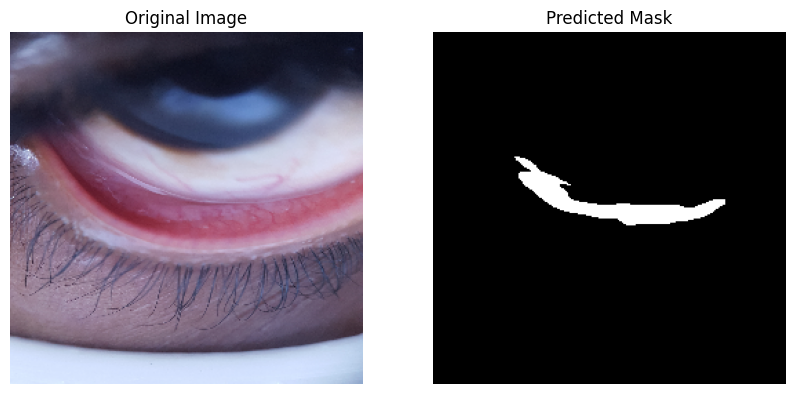

In [15]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Constants
MODEL_PATH = "conjunctiva_unet_model50.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256  # must match training

# 1. Load the trained model
model = UNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("[INFO] Model loaded and set to eval mode.")

# 2. Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = img.transpose(2, 0, 1)  # to CHW
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(DEVICE)  # add batch dim
    return img_tensor

# 3. Inference
def run_inference(image_path):
    img_tensor = preprocess_image(image_path)
    with torch.no_grad():
        pred = model(img_tensor)
    pred_mask = pred.cpu().numpy()[0, 0]  # remove batch and channel dims
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    return pred_mask

# 4. Visualize
new_image_path = r"D:\IITB\Conjunctiva Detection\Test50\20200124_161452.jpg"  # change to your test image
pred_mask = run_inference(new_image_path)

# Show original image & mask
original = cv2.imread(new_image_path)
original = cv2.resize(original, (IMG_SIZE, IMG_SIZE))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


[INFO] Model loaded and set to eval mode.
[INFO] Running standard inference...


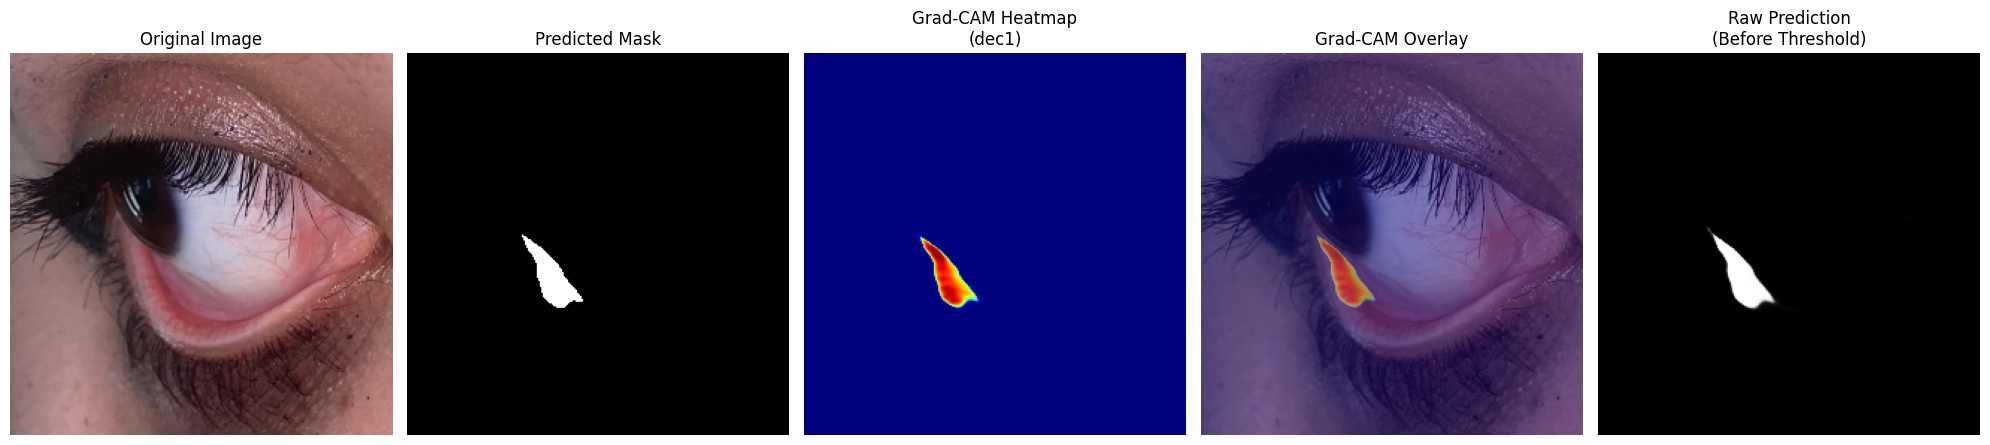

In [18]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap

# Constants
MODEL_PATH = r"D:\IITB\Conjunctiva Detection\Conjunctive_image_model\Conjunctive_image_model\conjunctiva_unet_model50.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256  # must match training

# 5. U-Net Model in PyTorch
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = CBR(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.out(d1))

# Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def generate_cam(self, input_tensor, class_idx=None):
        # Forward pass
        model_output = self.model(input_tensor)
        
        if class_idx is None:
            # For segmentation, use the mean of the output as the "score"
            score = model_output.mean()
        else:
            score = model_output[:, class_idx, :, :].mean()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        score.backward(retain_graph=True)
        
        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        
        # Pool the gradients across the spatial dimensions
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        
        # Weight the channels by corresponding gradients
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # ReLU on top of the heatmap
        heatmap = F.relu(heatmap)
        
        # Normalize the heatmap
        heatmap /= torch.max(heatmap)
        
        return heatmap.detach()

# 1. Load the trained model
model = UNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("[INFO] Model loaded and set to eval mode.")

# Initialize Grad-CAM with different target layers
# You can choose different layers for visualization
target_layers = {
    'bottleneck': model.bottleneck,
    'enc4': model.enc4,
    'dec1': model.dec1,
    'dec4': model.dec4
}

# 2. Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = img.transpose(2, 0, 1)  # to CHW
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(DEVICE)  # add batch dim
    return img_tensor

# 3. Inference with Grad-CAM
def run_inference_with_gradcam(image_path, target_layer_name='bottleneck'):
    img_tensor = preprocess_image(image_path)
    
    # Create Grad-CAM object
    target_layer = target_layers[target_layer_name]
    gradcam = GradCAM(model, target_layer)
    
    # Generate prediction
    with torch.no_grad():
        pred = model(img_tensor)
    pred_mask = pred.cpu().numpy()[0, 0]  # remove batch and channel dims
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255
    
    # Generate Grad-CAM heatmap
    heatmap = gradcam.generate_cam(img_tensor)
    heatmap_np = heatmap.cpu().numpy()
    
    # Resize heatmap to match input image
    heatmap_resized = cv2.resize(heatmap_np, (IMG_SIZE, IMG_SIZE))
    
    return pred_mask_binary, heatmap_resized, pred_mask

# 4. Visualization function
def visualize_gradcam(image_path, target_layer_name='bottleneck', alpha=0.4):
    # Load original image
    original = cv2.imread(image_path)
    original = cv2.resize(original, (IMG_SIZE, IMG_SIZE))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Run inference with Grad-CAM
    pred_mask, heatmap, pred_raw = run_inference_with_gradcam(image_path, target_layer_name)
    
    # Create overlay
    heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]  # Remove alpha channel
    overlay = original_rgb * (1 - alpha) + heatmap_colored * 255 * alpha
    overlay = overlay.astype(np.uint8)
    
    # Plot results
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 5, 1)
    plt.imshow(original_rgb)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 5, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.subplot(1, 5, 3)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Grad-CAM Heatmap\n({target_layer_name})")
    plt.axis("off")
    
    plt.subplot(1, 5, 4)
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")
    
    plt.subplot(1, 5, 5)
    plt.imshow(pred_raw, cmap='gray', vmin=0, vmax=1)
    plt.title("Raw Prediction\n(Before Threshold)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# 5. Function to compare different layers
def compare_gradcam_layers(image_path):
    original = cv2.imread(image_path)
    original = cv2.resize(original, (IMG_SIZE, IMG_SIZE))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20, 10))
    
    # Original image
    plt.subplot(2, 4, 1)
    plt.imshow(original_rgb)
    plt.title("Original Image")
    plt.axis("off")
    
    # Predicted mask
    pred_mask, _, _ = run_inference_with_gradcam(image_path, 'bottleneck')
    plt.subplot(2, 4, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    # Grad-CAM for different layers
    layer_names = ['enc4', 'bottleneck', 'dec4', 'dec1']
    positions = [3, 4, 6, 7]
    
    for i, layer_name in enumerate(layer_names):
        _, heatmap, _ = run_inference_with_gradcam(image_path, layer_name)
        
        plt.subplot(2, 4, positions[i])
        plt.imshow(heatmap, cmap='jet')
        plt.title(f"Grad-CAM: {layer_name}")
        plt.axis("off")
        
        # Create overlay
        plt.subplot(2, 4, positions[i] + 1 if positions[i] < 4 else positions[i] - 1)
        heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]
        overlay = original_rgb * 0.6 + heatmap_colored * 255 * 0.4
        overlay = overlay.astype(np.uint8)
        plt.imshow(overlay)
        plt.title(f"Overlay: {layer_name}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# 6. Run the analysis
new_image_path = r"D:\IITB\Conjunctiva Detection\Test50\43.png"  # change to your test image

print("[INFO] Running standard inference...")
pred_mask = run_inference(new_image_path)

# print("[INFO] Running Grad-CAM visualization...")
# # Visualize with different target layers
# visualize_gradcam(new_image_path, 'bottleneck')

# print("[INFO] Comparing different layers...")
# compare_gradcam_layers(new_image_path)

# You can also try different layers individually:
# visualize_gradcam(new_image_path, 'enc4')
visualize_gradcam(new_image_path, 'dec1')
# visualize_gradcam(new_image_path, 'dec4')

def run_inference(image_path):
    """Original inference function for compatibility"""
    img_tensor = preprocess_image(image_path)
    with torch.no_grad():
        pred = model(img_tensor)
    pred_mask = pred.cpu().numpy()[0, 0]  # remove batch and channel dims
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    return pred_mask